# Part 3: A Slightly More Complex Agent Based Model 

##### Authors: Bill Thompson (biltho@mpi.nl) and Limor Raviv (limor.raviv@mpi.nl) 
Please let us know if you have any comments, suggestions or questions regarding this notebook. 

---------------

## Summary
In this third tutorial, we will build a more complex simulation of agents using the commands in the second notebook, making our agents and their interactions a bit more ecologically valid. 

The major differences between these models are:
1. Instead of having agents with simple binary representaions (either [a] or [i]), agents in this model will have a continuous distribution around their prefered vowel.
2. The interactions in this model will be double-sided, so that both agents change their behavior after interacting.
3. Agents' personalities will be less rigid, allowing for more interesting changes during interaction: stubborn agents will align a little bit (instead of not at all), while flexible agents will align to a greater extent (but not fully).

We will make multiple simulations of interactions under different conditions, and see how this affects the distribution of vowels in the population. 


-------------- 


### 1. Setting up the network
First, let's create lists containing the possible biases for our agents. In this more complex model, agents have a range of possible vowels they can produce, which is distributed normally around a mean value on a single dimension. In this example, a mean of "-1" will correspond to [a] and a mean of "1" will corresponf to [i].

In [1]:
# Set the model Parameters

vowel_means = [-1., 1.] # set possible inital means for the distributions

personalities = ['F', 'S']

In [2]:
# Create a function that makes a single agent

def make_agent(vowel_mean, personality):
    return [vowel_mean, personality]


In [3]:
# Create a function that makes a population of random agents

import random

def make_population(N):
    
    population = []
    
    for i in range(N):
        
        m = random.randint(0,1)
        
        p = random.randint(0,1)
        
        agent = make_agent(vowel_means[m], personalities[p])
        
        population.append(agent)

    return population


# Check that this works by making a population of 8 agents
make_population(8)


[[-1.0, 'F'],
 [1.0, 'F'],
 [-1.0, 'S'],
 [1.0, 'S'],
 [1.0, 'F'],
 [-1.0, 'F'],
 [1.0, 'F'],
 [-1.0, 'S']]

### 2. Introducing more complex interactions
So far, this looked similar to our simple model, but now it's time to introduce some new features.

Because we want our agents to have more complex representations, we also need to write a function that selects a specific vowel from the distribution implied by the agent's mean,  for each interaction.

In [4]:
# Create a function that chooses a variant from a distribution centered around the agent's mean vowel

from copy import deepcopy 
from numpy.random import normal
import numpy

def choose_utterance(agent):   # sample from a normal distribution with SD=0.25 and mean of the teacher
    agent_utterance=normal(agent[0],.25)
    return agent_utterance

# Let's check that this works
# You can run this multiple times to see different chosen utterances for different agents

pop=make_population(4)
vowel = choose_utterance(pop[0])
print("The agent's mean was", pop[0][0])
print("The agent's chosen utterance is", vowel)

("The agent's mean was", 1.0)
("The agent's chosen utterance is", 0.8438989287675807)


In this new model, being flexible means that the agent shifts their vowel towards the other agents' utterance (by half of the distance between the mean and the utterance). This just means flexible agents adapt by going half way towards the other agent. 

In addition, stubborn agents are not completey stubborn and are only adapting by a little bit (by 1/10 of the distance between their mean and the other agent's utterance).

Let's try to write this function that changes the agents means according to their biased personalities, using simple conditions:

In [5]:
# Create a function that shifts the means of a flexible agent

def learn(utterance,agent):
    if agent[1] == "F":
        new_mean = (agent[0] + utterance) / 2.
    else:
        difference = abs(utterance-agent[0])
        if utterance > agent[0]:
            new_mean = agent[0] + (difference/10.)
        else:
            new_mean = agent[0] - (difference/10.)
    agent[0] = deepcopy(new_mean)


# Check that this works

# Create two agents with a mean of 1
stb_agent = [-1,'S']
flex_agent = [-1,'F']

# See what happens when each agent learns from an untterance of -1 (the other vowel)
learn(1,stb_agent)
learn(1,flex_agent)

print(stb_agent)
print(flex_agent)

[-0.8, 'S']
[0.0, 'F']


Now, we want both agents to update their representations after an interaction. This means that instead of having single-sided interactions with a listener and a producer, we now have an exchange of productions between the two agents in which each can learn from each other... 

For this, we'll write a new function that updates both agents based on their current utterances:

In [6]:
# Create a function in which both agents generate utterances and can learn from each other 

def interact((agent1,agent2)): 
    
    agent1_utterance = choose_utterance(agent1)
    agent2_utterance = choose_utterance(agent2)
    
    if agent1[0] == agent2[0]:
        pass # do nothing if the two agents have the same distributions 
    else:
        learn(agent2_utterance,agent1)
        learn(agent1_utterance, agent2)
    #return agent1_utterance, agent2_utterance, agent1, agent2
        

# Check if it works by uncommenting the "return" comment above 

interact(([-1,'F'],[1,'S']))

### 3. Simulation time!
Great! Now we have a double-sided interaction, and we can write a function that chooses random pairs from a populations, and then simulate multiple interactions between different agents.

In [7]:
# Create a function that chooses two agents from a population
from numpy.random import choice

def choose_pair(population):
    i = random.randint(0, len(population) - 1) # phyton counts from 0, so pop(8) is an error
    j = random.randint(0, len(population) - 1)
    
    while i == j:
        j = random.randint(0, len(population) - 1)
        
    return population[i], population[j]

# Create a function that simulates k interactions in a population of n agents

def simulate(n, k):
    
    initial_population = make_population(n)
    population=deepcopy(initial_population)
    
    for i in range(k):
        
        pair = choose_pair(population)
        
        interact(pair)
    
    return initial_population, population

Let's test that our simulation is working by looking at the results. Feel free to change the number of agents and the number of interactions as you please.

('The initial population was', [[-1.0, 'S'], [1.0, 'S'], [1.0, 'F'], [-1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [1.0, 'S'], [-1.0, 'F'], [1.0, 'S'], [-1.0, 'F'], [1.0, 'S'], [1.0, 'S'], [1.0, 'F'], [1.0, 'S'], [1.0, 'F'], [1.0, 'F'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [-1.0, 'S'], [-1.0, 'S'], [-1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [1.0, 'F'], [-1.0, 'S'], [-1.0, 'F'], [-1.0, 'S'], [1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [1.0, 'F'], [1.0, 'F'], [-1.0, 'S'], [-1.0, 'F'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'F'], [-1.0, 'S'], [-1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [-1.0, 'S'], [-1.0, 'F'], [1.0, 'S'], [-1.0, 'S'], [1.0, 'F'], [-1.0, 'S'], [1.0, 'F'], [-1.0, 'S'], [-1.0, 'F'], [-1.0, 'F'], [-1.0, 'S'], [-1.0, 'F'], [1.0, 'S'], [-1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [1.0, 'S'], [-1

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


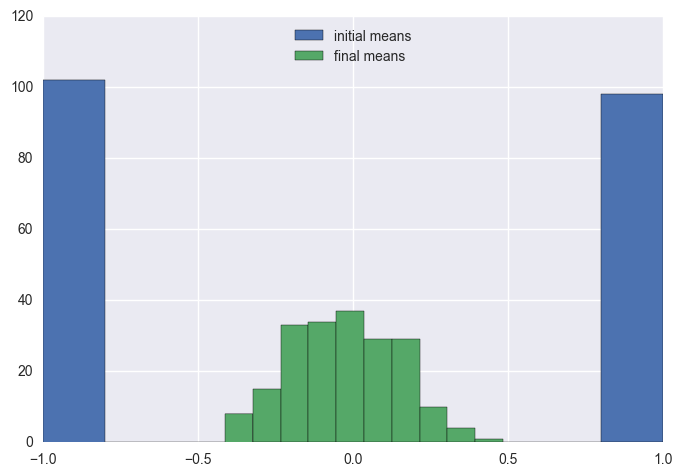

In [8]:
# Run a simulation with 200 agents and 2000 interactions

initial_population, new_population = simulate(200,2000)

print("The initial population was", initial_population)
print("The new population is", new_population)

# Plot the agents' initial and final means

%matplotlib inline 
# put plot in the notebook
import matplotlib.pyplot as plt # importing a plotting library
import seaborn as sns # make the plot look better

initial_means = []
final_means = []

for agent in range(len(initial_population)):
    initial_means.append(initial_population[agent][0])
    final_means.append(new_population[agent][0])
    
plt.hist(initial_means, label='initial means')
plt.hist(final_means, label='final means')
plt.legend(loc='upper center')
plt.show()  

In the plot above, the clustering of orange agents (final population) shows convergence, while the spread distribution (blue, initial population) implies divergence.

In most simulations, you'll see convergence.

But since as you've seen, each simulation yields different outcomes in terms of which variant agents have converged on, we need to run multiple simulations and compute their mean to get a more reliable picture of what's happening. So let's make a function that computes the final means of several simulations.

In [9]:
# Create a function to compute the means of the vowels in the population

def compute_mean(population):
    t=0.
    for agent in population:
        t += agent[0]
    return t/len(population)

# Create a function that runs multiuple simulations and returns the final mean of each of them

def batch_simulate(n,k,s): #n=pop size, k=no. of interactions, s=no. of simulations
    batch_final=[]
    for i in range(s):
        initial_population, new_population = simulate(n, k)
        new_proportion=compute_mean(new_population)
        batch_final.append(new_proportion)
    return batch_final
        

So what's going on? Let's run some simulations! This might take a few minutes to complete.

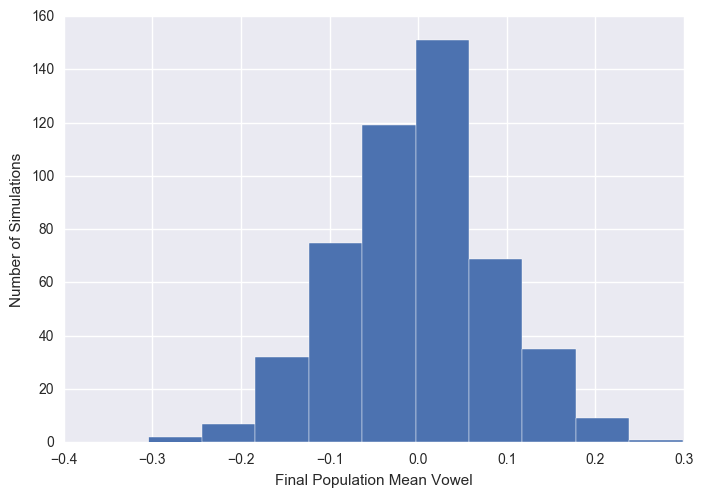

In [10]:
# Run 500 simulations
results = batch_simulate(200,2000,500)

# Plot the result

plt.hist(results, edgecolor = 'white')
plt.xlabel('Final Population Mean Vowel')
plt.ylabel('Number of Simulations')

What you can see in the histogram above is that there is a nice normal distribution around 0. That is, **in most simulations, the population converges on the mean between the two initial variants**. This result is exactly what we expect given prior studies with similar models.

So let's probe this model a bit more by looking at effect of stubborn agents in the population. 

As we did in the second tutorial, we will see if the number of stubborn agents affects the trend of convergence towards the mean. Since we changed the agents learn in this model, the result might be different this time. Specifically, stubborn agents in the new model are not longer rigid and can align to a new utterance, just to a lesser degree than flexible agents.

So let's rewrite the functions defined above so that they created biased populations where we control the number of stubborn agents:

In [11]:
# Modify the function to make populations of N agents with a given number of stubborn agents (st)

def make_population_biased(N,st):
    
    population = []
    
    for i in range(st):
        
        m = random.randint(0,1)
        
        agent = make_agent(vowel_means[m], personalities[1])
        
        population.append(agent)
    
    for i in range(N-st):
        
        m = random.randint(0,1)
        
        agent = make_agent(vowel_means[m], personalities[0])
        
        population.append(agent)

    return population



# Modify the function so that it calls our biased population 

def simulate_biased(n, k, st):  #st=no. of stubborn
    
    initial_population = make_population_biased(n,st)
    population=deepcopy(initial_population)
    
    for i in range(k):
        
        pair = choose_pair(population)
        
        interact(pair)
        
    return initial_population, population

We can check that our changes work by simulating one population first. You can change the number of stubborn agents to see how it affects the results.

('The initial population was', [[-1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [1.0, 'S'], [1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [-1.0, 'S'], [-1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [-1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [-1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [1.0, 'F'], [1.0, 'F'

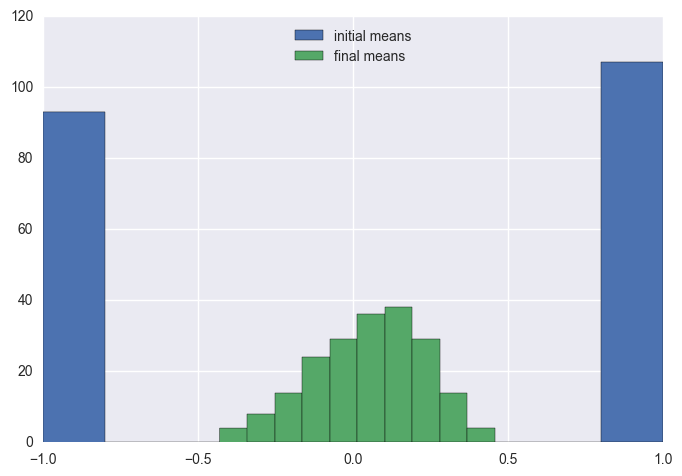

In [12]:
# Simulate a population with 50 stubborn agents
old_pop, new_pop =simulate_biased(200,2000,50)

print("The initial population was", old_pop)
print("The new population is", new_pop)

# Plot the agents' initial and final means

initial_means = []
final_means = []

for agent in range(len(old_pop)):
    initial_means.append(old_pop[agent][0])
    final_means.append(new_pop[agent][0])
    
plt.hist(initial_means, label='initial means')
plt.hist(final_means, label='final means')
plt.legend(loc='upper center')
plt.show()  

Because we want to look at the degree of convergence and how it is affected by stubborn agents, we need a measure to capture variance, like the standard deviation (SD). For now, we will write a function that stores the SDs of the final means in multiple simulations. This will give us an idea of how diverged the population was after interacting. 

In [13]:
# Create a function to compute the means of the vowels in the population

def compute_SD(population):
    pop_means=[]
    for agent in population:
        pop_means.append(deepcopy(agent[0]))
    pop_SD= numpy.std(pop_means)
    return pop_SD

# Rewrite the batch simulation function so that it runs s simulations for each possible proportion of stubborn agents (possible_sts)

def batch_simulate_biased(n,k,s): #n-pop size, k=no. of interactions, s=no. of simulations for each bias
    
    all_results=[]
    
    possible_sts = [0, int(n / 10.), int(n / 4.), int(n / 2.), int(3*n / 4.), n]
    # This time, we'll test 0%, 10%, 25%, 50%, 75% and 100% stubborn agents
    
    for st in possible_sts:
        
        print(st)
    
        current_results = []  # print the progress of the simulations 
    
        for i in range(s):
            initial_population, new_population = simulate_biased(n, k, st)
            sd = compute_SD(new_population)
            current_results.append(sd)
        
        all_results.append([st,current_results])
    
    return all_results


Now, let's run a few simulations with different proportions of stubborn agents, and see what happens:

In [14]:
# Run 50 simulations of each stubborness proportions in a community of 200 agents 
results = batch_simulate_biased(200,2000,50)


0
20
50
100
150
200


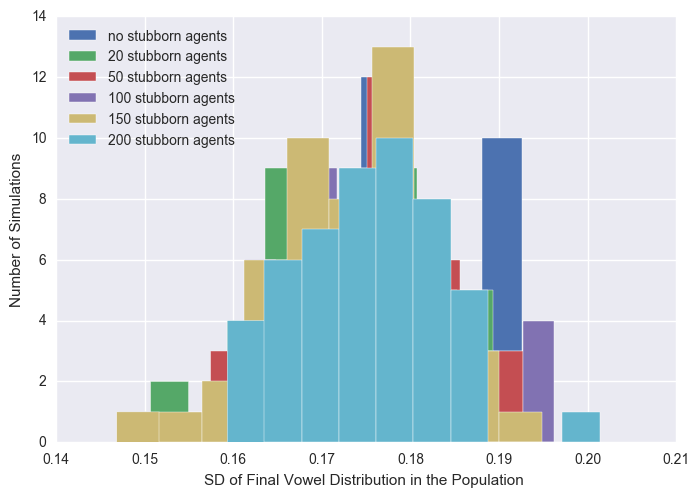

In [15]:
# Plot the results of the simulations 
        
plt.hist(results[0][1], label='no stubborn agents',edgecolor = 'white')
plt.hist(results[1][1], label='20 stubborn agents',edgecolor = 'white')
plt.hist(results[2][1], label='50 stubborn agents',edgecolor = 'white')
plt.hist(results[3][1], label='100 stubborn agents',edgecolor = 'white')
plt.hist(results[4][1], label='150 stubborn agents',edgecolor = 'white')
plt.hist(results[5][1], label='200 stubborn agents',edgecolor = 'white')
plt.legend(loc='best')
plt.xlabel('SD of Final Vowel Distribution in the Population ')
plt.ylabel('Number of Simulations')     
plt.show()  

As you can see, there seems to be no relationship between the degree of variance and the number of stubborn agents in the population, suggesting that all populations converged similarly regardless of how stubborn agents were. Looking at the relatively low SDs, this is presumably because in this new model, 2000 interactions were enough to allow the entire population to converge even if stubborn agents did so slower.

So let's do something more interesting. Let's look at how convergence varies with **population size**.

For this, we'll rewrite the function so that it simulates different sizes of populations (n) instead of different proportions of stubborn agents. We'll choose n= 10, 150, 250, 350, 450, 550 and 650. (Feel free to change this as you please).

In [16]:
# Rewrite the batch simulation function so that it runs s simulations for each possible population size (possible_size)

def batch_simulate_size(k,s): # k=no. of interactions, s=no. of simulations for each bias
    
    all_results=[]
    
    possible_size = [50, 150, 250, 350, 450, 550, 650]
        
    for n in possible_size:
        
        print(n)
    
        current_results = []  # print the progress of the simulations 
    
        for i in range(s):
            initial_population, new_population = simulate(n, k)
            sd = compute_SD(new_population)
            current_results.append(sd)
        
        all_results.append([n,current_results])
    
    return all_results


Let's run some simulations with different population sizes: 

In [17]:
# Run 50 simulations of each population size
results = batch_simulate_size(2000,50)


50
150
250
350
450
550
650


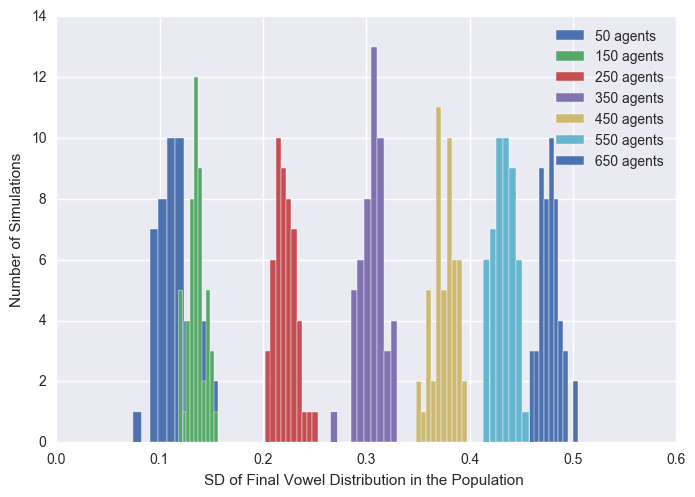

In [18]:
# Plot the results of the simulations 
        
plt.hist(results[0][1], label='50 agents',edgecolor = 'white')
plt.hist(results[1][1], label='150 agents',edgecolor = 'white')
plt.hist(results[2][1], label='250 agents',edgecolor = 'white')
plt.hist(results[3][1], label='350 agents',edgecolor = 'white')
plt.hist(results[4][1], label='450 agents',edgecolor = 'white')
plt.hist(results[5][1], label='550 agents',edgecolor = 'white')
plt.hist(results[6][1], label='650 agents',edgecolor = 'white')
#plt.hist(results[7][1], label='1000 agents',edgecolor = 'white')
plt.legend(loc='best')
plt.xlabel('SD of Final Vowel Distribution in the Population ')
plt.ylabel('Number of Simulations')     
plt.show()  

This plot shows that population size mediates convergence: given the same number of interactions, smaller populations show lower SDs and therefore higher degrees of convergence. As populations grow, the less converged they are at their final stage. This is reasonable, since bigger populations require more time to reach the same level of connectivity between agents, and have more variance to begin with. 

Thus, we may predict that given more time to interact, bigger populations will show the same levels of convegrence as smaller populations. We can quickly check this by running a simulation with more interactions (say, 5 times more):

In [19]:
# Run 50 simulations of each population size
results = batch_simulate_size(10000,50)


50
150
250
350
450
550
650


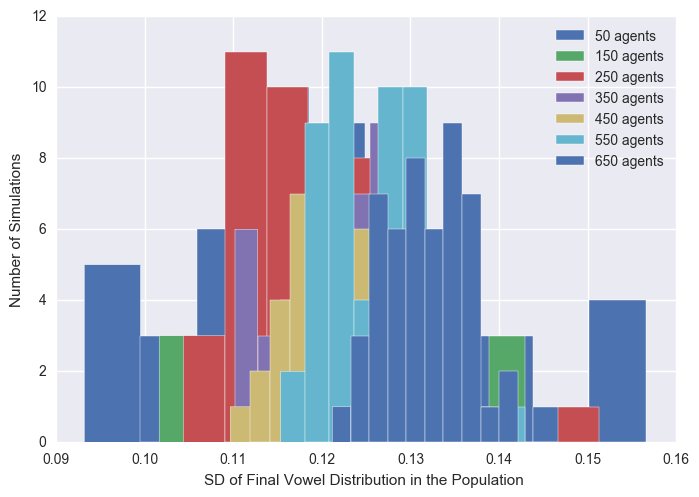

In [20]:
# Plot the results of the simulations 
        
plt.hist(results[0][1], label='50 agents',edgecolor = 'white')
plt.hist(results[1][1], label='150 agents',edgecolor = 'white')
plt.hist(results[2][1], label='250 agents',edgecolor = 'white')
plt.hist(results[3][1], label='350 agents',edgecolor = 'white')
plt.hist(results[4][1], label='450 agents',edgecolor = 'white')
plt.hist(results[5][1], label='550 agents',edgecolor = 'white')
plt.hist(results[6][1], label='650 agents',edgecolor = 'white')
#plt.hist(results[7][1], label='1000 agents',edgecolor = 'white')
plt.legend(loc='best')
plt.xlabel('SD of Final Vowel Distribution in the Population ')
plt.ylabel('Number of Simulations')     
plt.show()

Indeed, the results show that with more interactions, there is little to no difference between the different-sized populations, and all eventually reach similar levels of convergence. 

## Wrapping up
So you did it! You finished the tutorial and made a model with more complex agents and complex interactions. 

Hopefully, now you feel confident enough to change different parts of the code, or add your own new features. 

Good luck with your model!

Bill & Limor